In [1]:
import sys
sys.path.append('../src/')
sys.path.append('../tests/')
from urllib.parse import urlparse
from tenzing.core.model.typeset import *
from tenzing.core.model.types import *
from tenzing.core.model.typesets import *
from tenzing.core.model.functional import type_cast, type_inference

import os
from series import get_series, infer_series_type_map, get_series_type_map

import datetime
import numpy as np
import networkx as nx
from functools import reduce
import operator
import pandas.api.types as pdt

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



%matplotlib inline

In [2]:
series = pd.Series(["1.0", "2.0", "3.0"], name="string_num")
ts = tenzing_complete_set()

initial_type = ts.get_series_type(series.copy(deep=True))
converted_type = ts.infer_series_type(series.copy(deep=True))

print(initial_type, converted_type)
converted_series = ts.cast_series(series.copy(deep=True))
not (converted_series.eq(series) ^ (converted_series.isna() & series.isna())).all()

tenzing_string tenzing_integer


True

In [3]:
series = pd.Series(['1.0', '2.0'])
tenzing_integer.get_relations()[tenzing_string].is_relation(series)

tenzing_float.get_relations()[tenzing_string].is_relation(series)


False

In [4]:
int('1.0')

ValueError: invalid literal for int() with base 10: '1.0'

In [ ]:
series = pd.Series(range(20), name="int_str_range").astype("str")

ts = tenzing_complete_set()

inferred_type = ts.infer_series_type(series)

series_convert = ts.cast_series(series.copy())

initial_type_after_convert = ts.get_series_type(series_convert.copy())

inferred_type_after_convert = ts.get_series_type(series_convert.copy())

series_convert2 = ts.cast_series(series_convert.copy())

assert inferred_type == initial_type_after_convert
assert initial_type_after_convert == inferred_type_after_convert
assert series_convert.isna().eq(series_convert2.isna()).all()
assert (
    series_convert[series_convert.notna()]
    .eq(series_convert2[series_convert2.notna()])
    .all()
)

In [ ]:
series.astype('object')

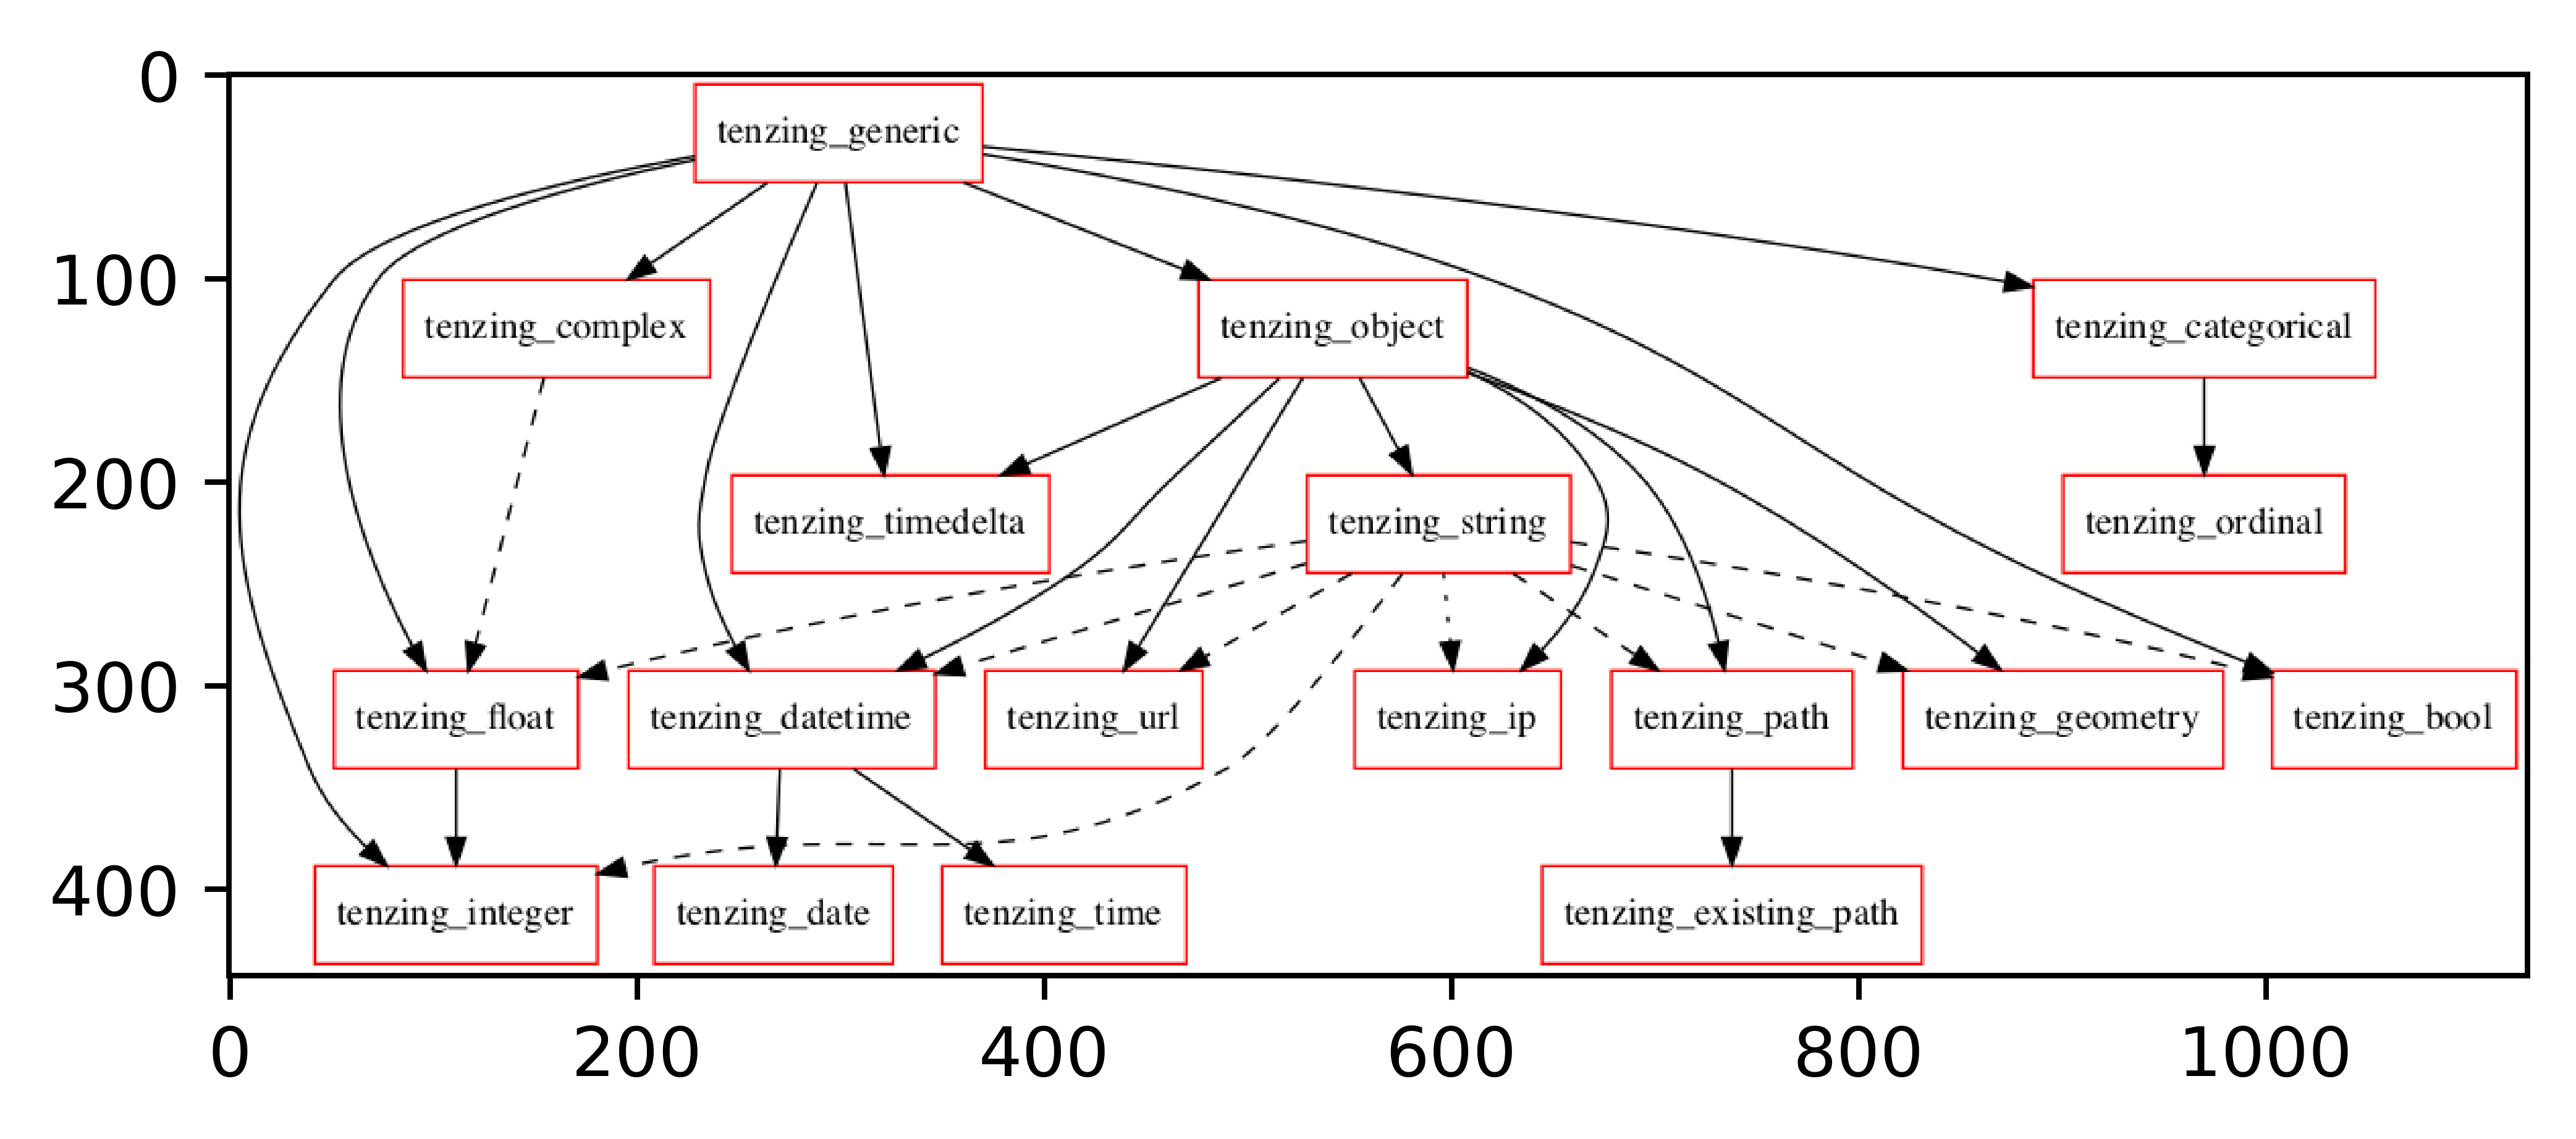

In [5]:
ts.plot_graph()

In [6]:

df = pd.DataFrame(
        {
            "item_id": [1, 1, 3],
            "item_cost": [2.1, 3.5, 4],
            "item_name": ["orange", "orange", "apple"],
            "sale_date": pd.to_datetime(
                [
                    datetime.date(2011, 1, 1),
                    datetime.date(2012, 1, 2),
                    datetime.date(2013, 1, 1),
                ]
            ),
            "store_location": pd.Series(
                ["POINT (12 42)", "POINT (100 42.723)", "POINT (0 0)"]
            ),
            "COGS": pd.Series([np.nan, 1.1, 2.1]).astype(str),
            "is_still_available": [np.inf, False, True],
            "is_expired": ["True", "false", "False"],
            "is_person": ["Y", "N", "Y"],
            "website": [
                "http://www.google.com",
                "http://www.bing.com",
                "http://www.duckduckgo.com",
            ],
            "complex_record": [np.complex(1, 2), np.complex(3, 4), np.complex(5, 6)],
            "complex_float": [np.complex(1, 0), np.complex(3, 0), np.complex(5, 0)],
            "path_linux": [
                r"/home/user/test.txt",
                r"/home/user/test.bat",
                r"/home/user/test.sh",
            ],
            "path_win": [
                r"C:\Users\test.txt",
                r"C:\Users\test.bat",
                r"C:\Users\test.sh",
            ],
        }
    )
x = tenzing_complete_set()
y = tenzing_complete_set()

tdf = x.cast_to_inferred_types(df)

/Users/ian/anaconda3/envs/tenz_test2/lib/python3.7/site-packages/numpy/lib/type_check.py:204: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  return val.imag


In [7]:
x.column_type_map

{}

In [10]:
y.cache(tdf)
y.column_type_map

{'item_id': tenzing_integer,
 'item_cost': tenzing_float,
 'item_name': tenzing_string,
 'sale_date': tenzing_date,
 'store_location': tenzing_geometry,
 'COGS': tenzing_float,
 'is_still_available': tenzing_object,
 'is_expired': tenzing_bool,
 'is_person': tenzing_bool,
 'website': tenzing_url,
 'complex_record': tenzing_complex,
 'complex_float': tenzing_complex,
 'path_linux': tenzing_path,
 'path_win': tenzing_path}

In [6]:
tdf['sale_date']

0   2011-01-01
1   2012-01-02
2   2013-01-01
Name: sale_date, dtype: datetime64[ns]

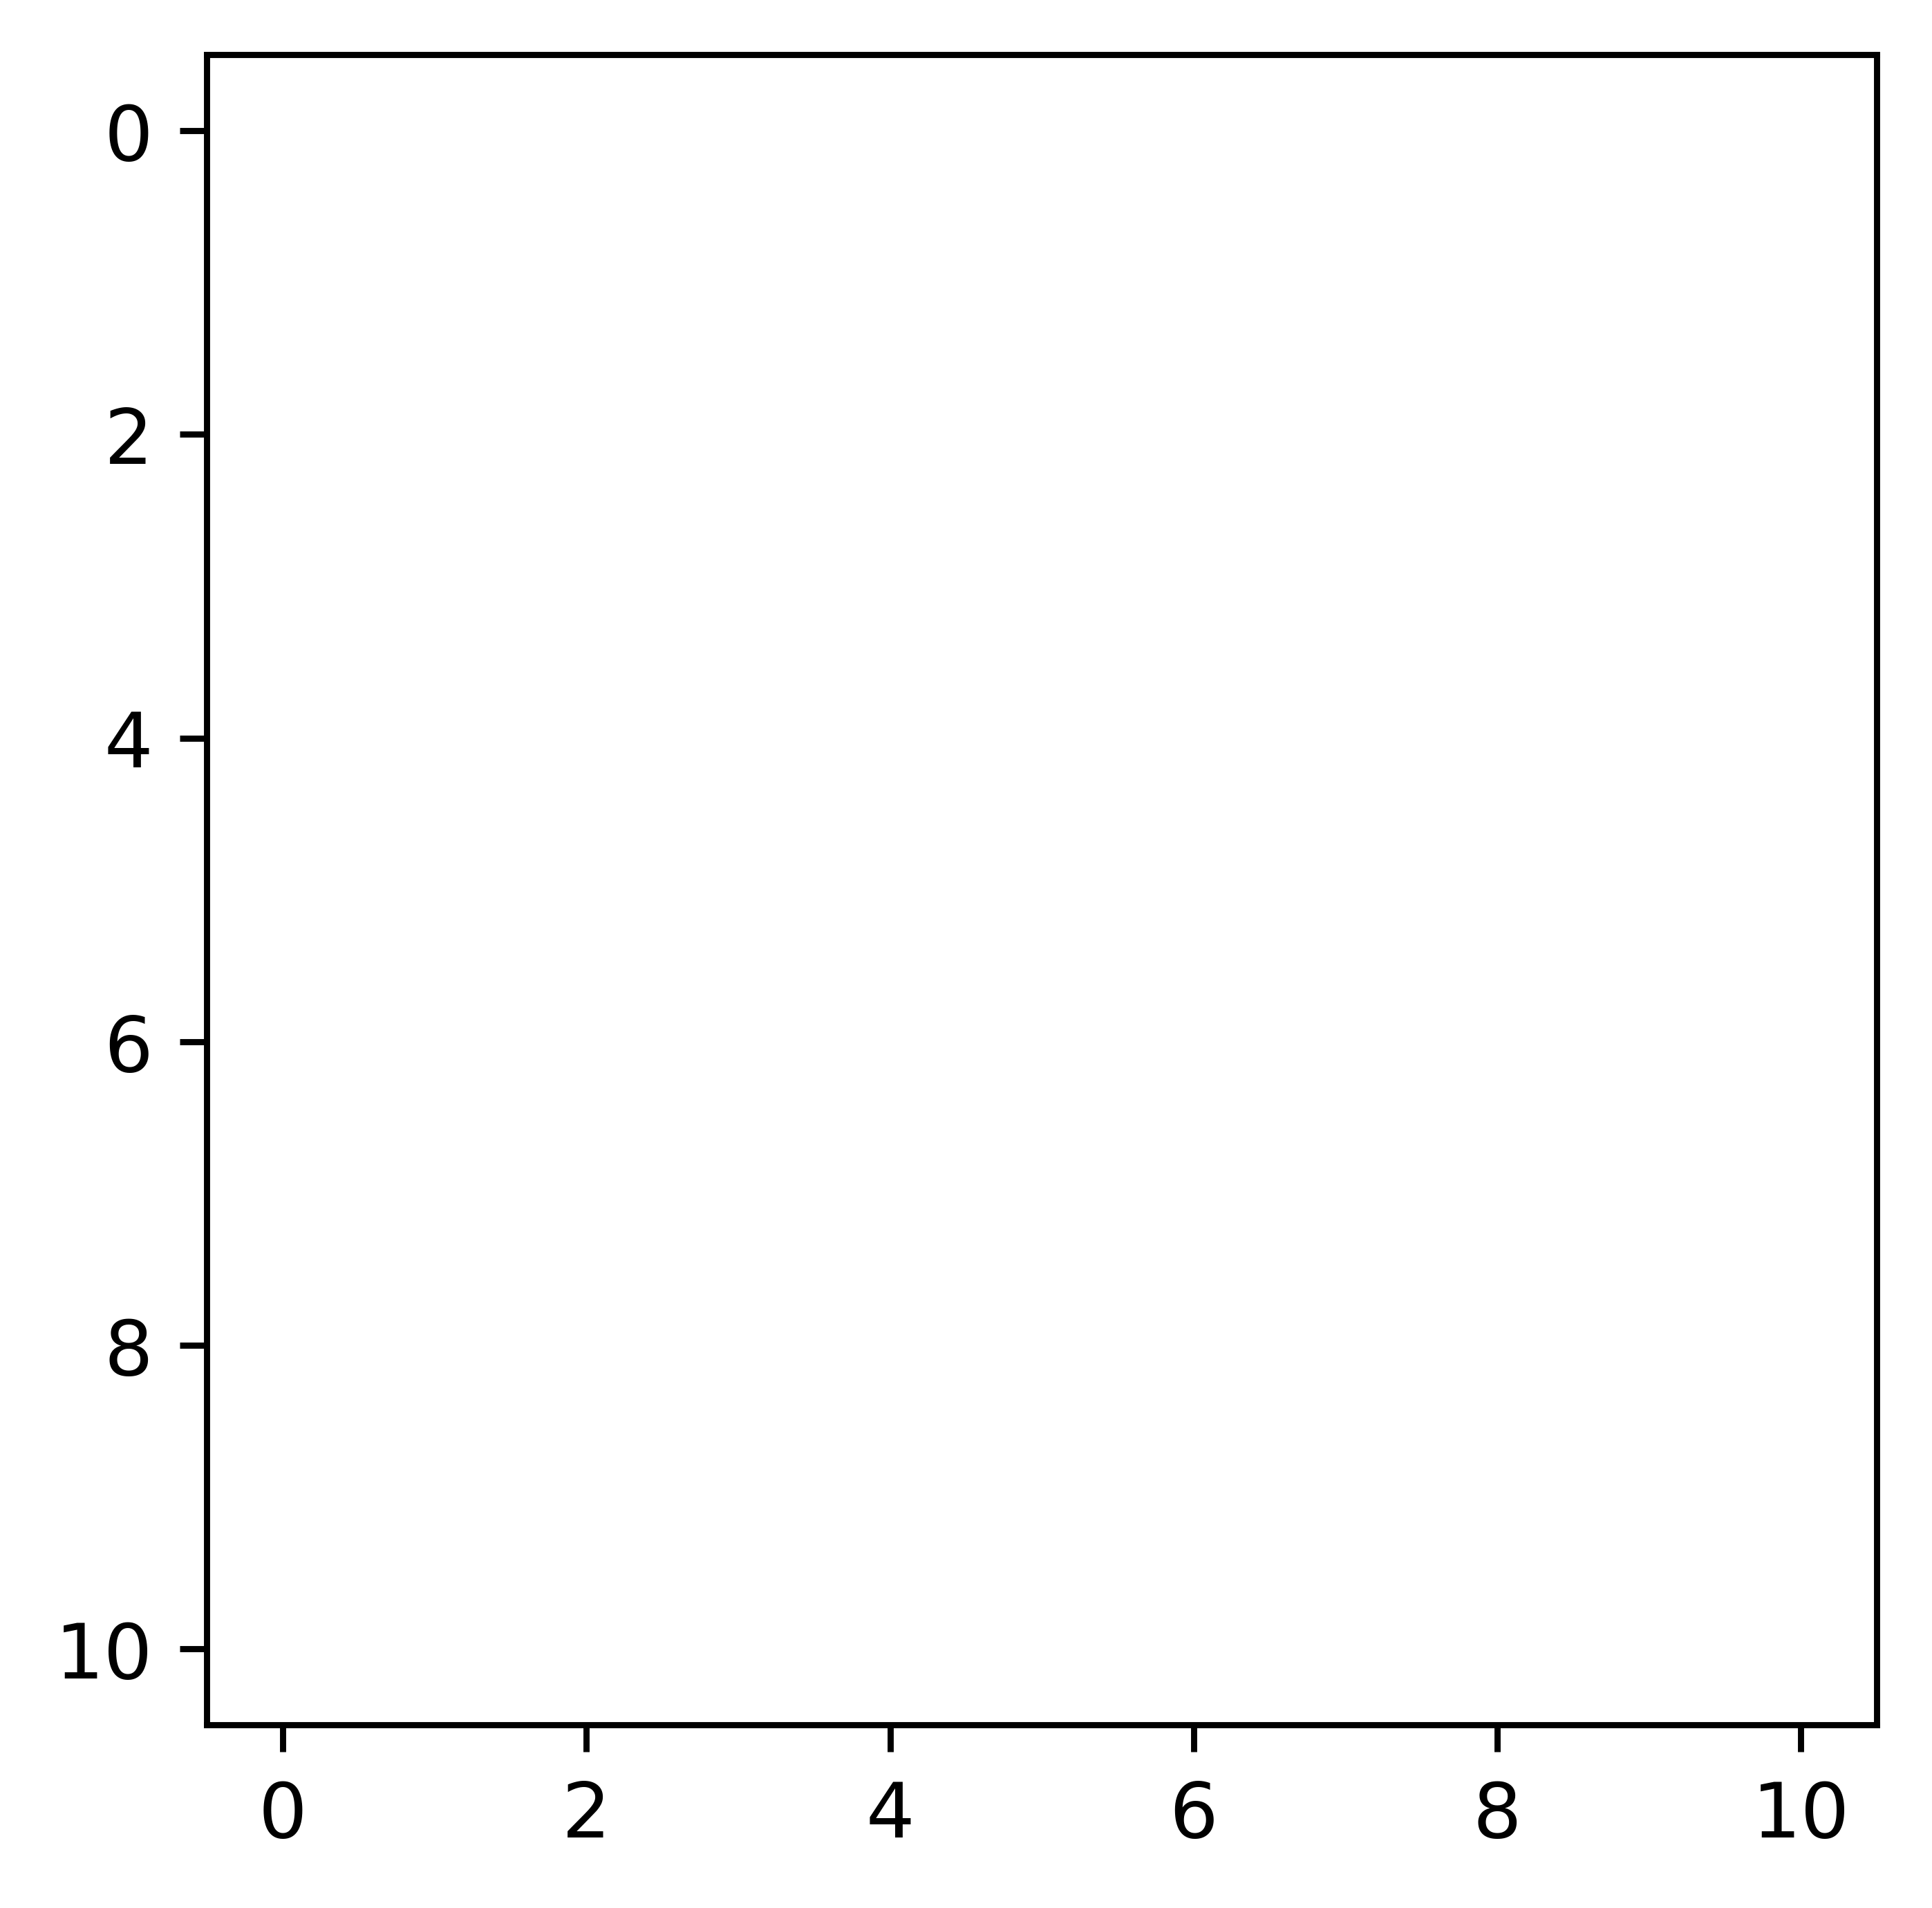

In [5]:
x.plot_graph()

In [ ]:
from urllib.parse import urlparse
def test_url(series):
    try:
        return (
            series.apply(urlparse).apply(lambda x: all((x.netloc, x.scheme))).all()
        )
    except AttributeError:
        return False
test_url(df['website'])

In [7]:
series = df['website']
y.infer_series_type(series)

Generic[tenzing_url]

In [8]:
y.cast_series(series)

0        (http, www.google.com, , , , )
1          (http, www.bing.com, , , , )
2    (http, www.duckduckgo.com, , , , )
Name: website, dtype: object

In [9]:
from tenzing.core.partitioners import generic

In [10]:
print(tenzing_integer.get_relations()[tenzing_float].inferential)

False


In [11]:
tenzing_integer

tenzing_integer

In [12]:
from pathlib import Path, PurePath

In [13]:
PurePath('/home/user/test.txt').exists()

AttributeError: 'PurePosixPath' object has no attribute 'exists'

In [3]:
s = pd.Series([True, False, np.nan])
s in tenzing_bool

True

In [1]:
from shapely.errors import WKTReadingError

In [5]:
from shapely.geometry.base import BaseGeometry

In [11]:
x = pd.Series([1, 2, np.nan], dtype='Int64')
df = pd.DataFrame({'x': x})
df.to_csv('temp.csv')
pd.read_csv('temp.csv').x.dtype

dtype('float64')

False